In [110]:
from source.ion_channel import IonChannel
from source.patch_clamp import PatchClamp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from source.moreka import AxonData
import plotly.express as px
import plotly.graph_objects as go


## Load some data

(5998,)


<Axes: xlabel='time', ylabel='signal'>

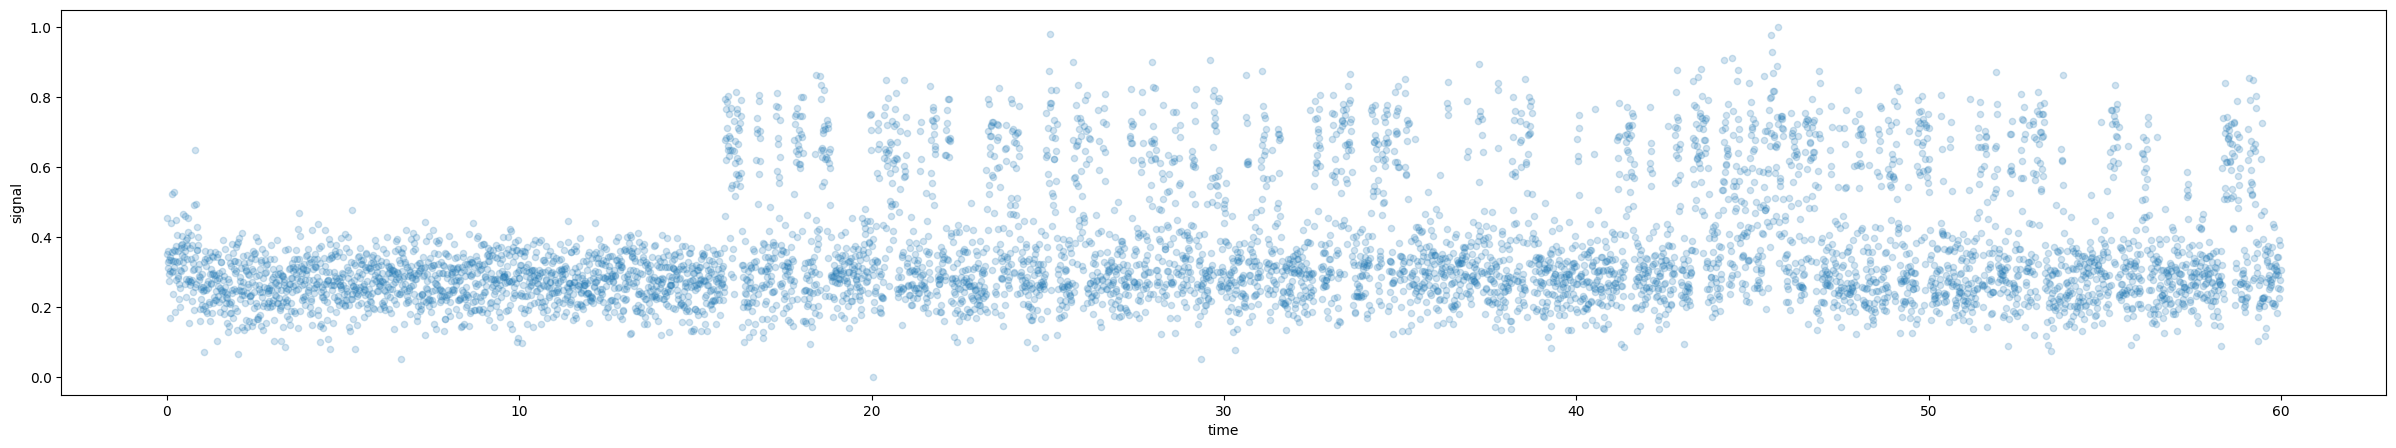

In [111]:
data = AxonData(dirname='../data')
df = data[20].iloc[::100, :]

# remove outliers in signal
df = df[np.abs(df.signal - df.signal.mean()) <= (4 * df.signal.std())]
# all signals must be positive
df = df[df.signal > 0]

# normalize signal to be between 0 and 1
df.signal = (df.signal - np.min(df.signal)) / (np.max(df.signal) - np.min(df.signal))

X = df.signal.values
print(X.shape)
df.plot(x='time', y='signal', figsize=(30, 5), kind='scatter', alpha=0.2)


In [112]:
def prepare_test_data(X, y, x_len=50, y_len=1):
    X_lstm = []
    y_lstm = []
    for i in range(len(X)):
        for j in range(x_len, len(X[i]) - x_len):
            idx = i
            # randomly select a point in X[idx] which its index is greater than x_len and smaller than len(X[idx]) - x_len
            y_index = j
            y_lstm.append(y[idx][y_index:y_index + y_len])
            # x is the previous x_len points of y and x_len points after y, excluding y
            x_before = X[idx][y_index - x_len:y_index]
            x_after = X[idx][y_index + 1:y_index + x_len + 1]
            X_lstm.append(np.stack([np.concatenate((x_before, x_after))]))
            
    return np.array(X_lstm), np.array(y_lstm)

In [113]:
X_lstm, y_lstm = prepare_test_data([X], [X])
print(X_lstm.shape)
print(y_lstm.shape)

(5898, 1, 100)
(5898, 1)


In [114]:
# load model and predict
model = keras.models.load_model('models/LSTM_normalized_50points_behind_50points_ahead_classification_with_artificial_data.keras')

In [115]:
y_pred = model.predict(X_lstm.reshape(-1, 100))
y_pred = np.argmax(y_pred, axis=1)

185/185 [==============================] - 2s 9ms/step


(200.0, 600.0)

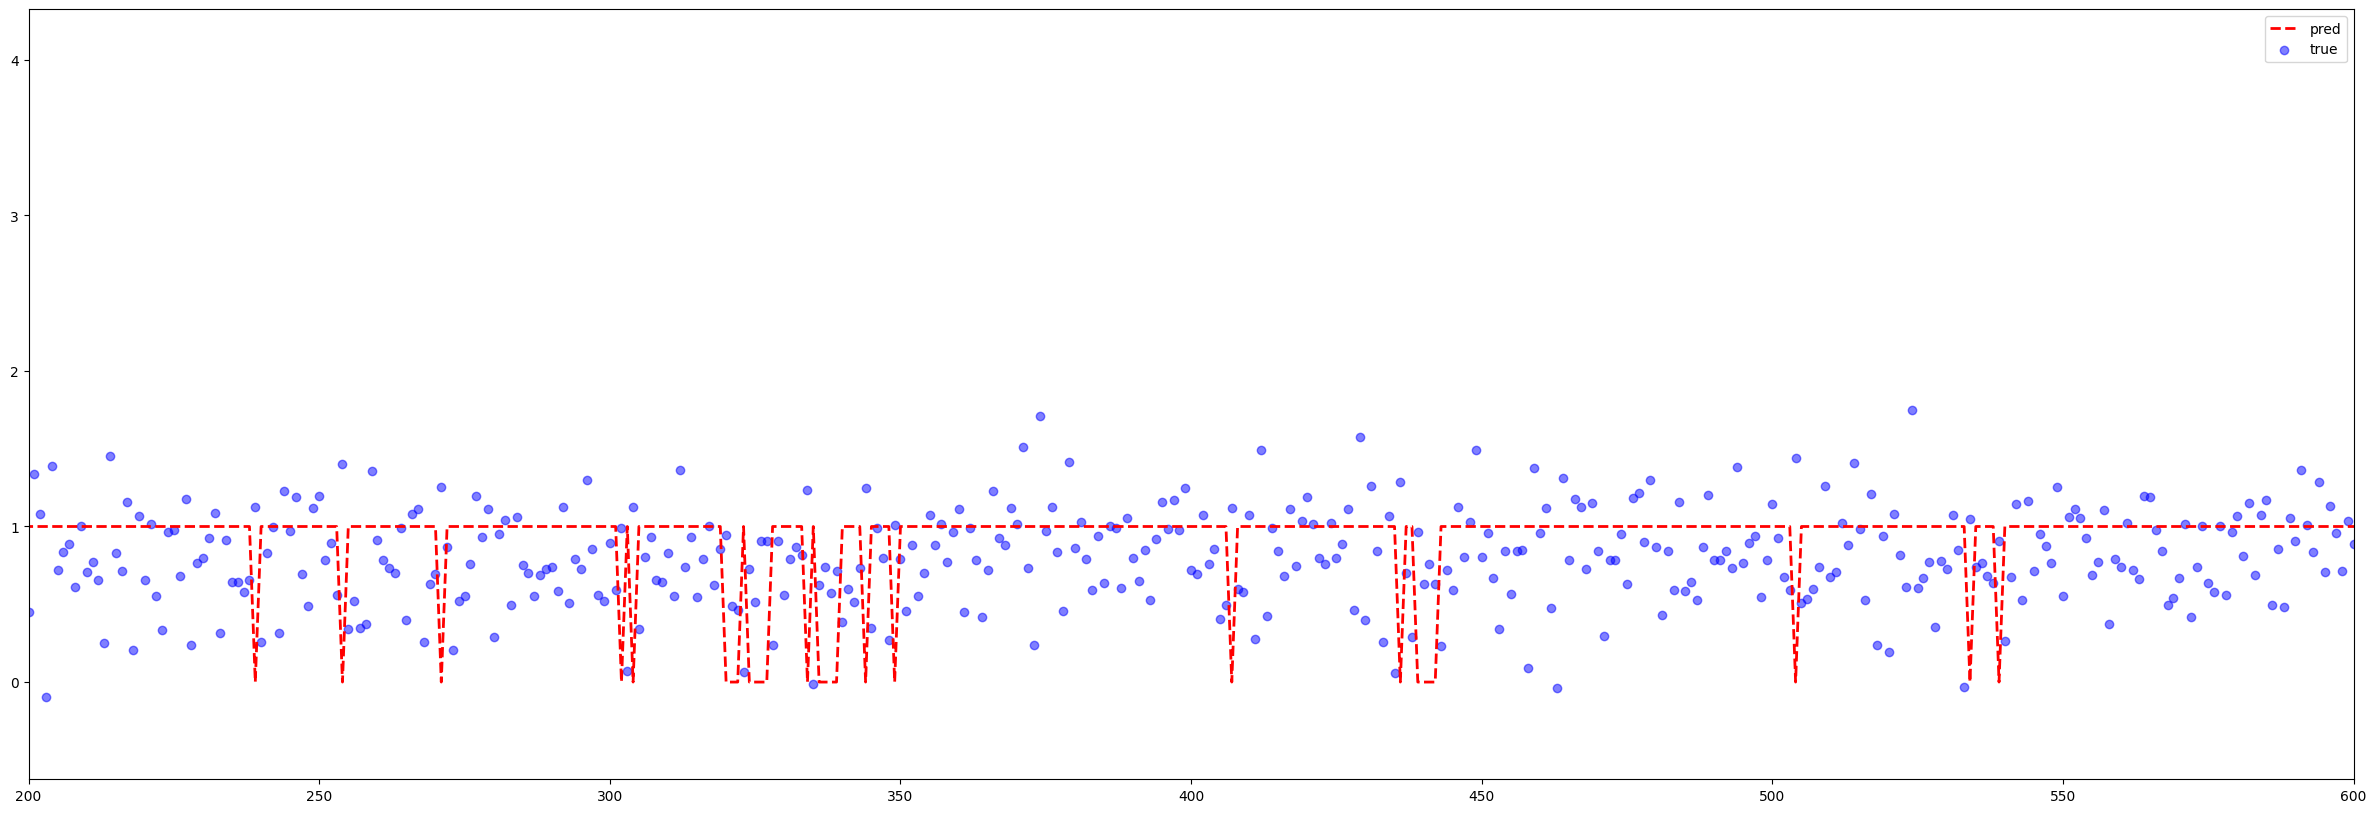

In [116]:
plt.figure(figsize=(30, 10))

# start from 50
plt.plot(range(50, 50 + len(y_pred)), y_pred, color='red', label='pred', linestyle='dashed', linewidth=2)
# X_test_ion scatter plot
plt.scatter(range(len(X)), X * 4.5 - 0.4, color='blue', label='true', alpha=0.5)
plt.legend()
plt.xlim(200, 600)

In [117]:

# Assuming y_pred and X are your data
x = np.arange(50, 50 + len(y_pred))
fig = px.line(x=x, y=y_pred, color_discrete_sequence=['red'], labels={'x': '', 'y': 'pred'})
fig.add_trace(go.Scatter(x=np.arange(len(X)), y=X * 4.5 - 0.4, mode='markers', marker_color='blue', marker_opacity=0.5, name='true'))
# fig.update_layout(legend_title_text='', width=1200, height=400, xaxis_range=[200, 600])
fig.show()